# Streaming application using Spark Structured Streaming
## Initialising application name and number of working processors

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark import SparkConf

# Part 1
# Setting application name and number of working processors
conf = SparkConf().setAppName("Pedestrian Count").setMaster("local[2]").set('spark.sql.session.timeZone', 'UTC')
spark = SparkSession.builder.config(conf=conf).getOrCreate()

## Defining data scheme and load file into csv

In [2]:
from pyspark.sql.types import *

# Defining the schema
sensor_schema = StructType([
    StructField('sensor_id', IntegerType(), True),
    StructField('sensor_description', StringType(), True),
    StructField('sensor_name', StringType(), True),
    StructField('installation_date', TimestampType(), True),
    StructField('status', StringType(), True),
    StructField('note', StringType(), True),
    StructField('direction_1', StringType(), True),
    StructField('direction_2', StringType(), True),
    StructField('latitude', DoubleType(), True),
    StructField('longitude', DoubleType(), True),
    StructField('location', StringType(), True)
])

# Load csv into dataframe
sensor_df = spark.read.format("csv")\
    .option("header", "true")\
    .schema(sensor_schema)\
    .option("timestampFormat", "y/M/d")\
    .load("Pedestrian_Counting_System_-_Sensor_Locations.csv")

## Ingest streaming data in spark streaming

In [3]:
topic = "pedestrian_count"
raw_df = spark.readStream.format("kafka") \
  .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
  .option("subscribe", topic) \
  .load()

In [4]:
raw_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [5]:
# Obtain key value pair only
raw_df = raw_df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

In [6]:
# Define a string type schema to do initial reading of data
pedestrian_schema = StructType([
    StructField('ID', StringType(), True),
    StructField('Date_Time', StringType(), True),
    StructField('Year', StringType(), True),
    StructField('Month', StringType(), True),
    StructField('Mdate', StringType(), True),
    StructField('Day', StringType(), True),
    StructField('Time', StringType(), True),
    StructField('Sensor_ID', StringType(), True),
    StructField('Sensor_Name', StringType(), True),
    StructField('Hourly_Counts', StringType(), True),
    StructField('ts', StringType(), True)
])

# 
from pyspark.sql import functions as F
raw_df=raw_df.select(F.from_json(F.col("value").cast("string"), pedestrian_schema).alias('parsed_value'))

raw_df = raw_df.select(
                    F.col("parsed_value.ID").alias("ID"),
                    F.col("parsed_value.Date_Time").alias("Date_Time"),
                    F.col("parsed_value.Year").alias("Year"),
                    F.col("parsed_value.Month").alias("Month"),
                    F.col("parsed_value.Mdate").alias("Mdate"),
                    F.col("parsed_value.Day").alias("Day"),
                    F.col("parsed_value.Time").alias("Time"),
                    F.col("parsed_value.Sensor_ID").alias("Sensor_ID"),
                    F.col("parsed_value.Sensor_Name").alias("Sensor_Name"),
                    F.col("parsed_value.Hourly_Counts").alias("Hourly_Counts"),
                    F.col("parsed_value.ts").alias("ts")
                )

## Create output sink for the stream by

In [7]:
query = raw_df.writeStream.outputMode("append").format("console").option("truncate", "false").trigger(processingTime='5 seconds').start()

In [8]:
query.stop()

## Screenshot of output in console.
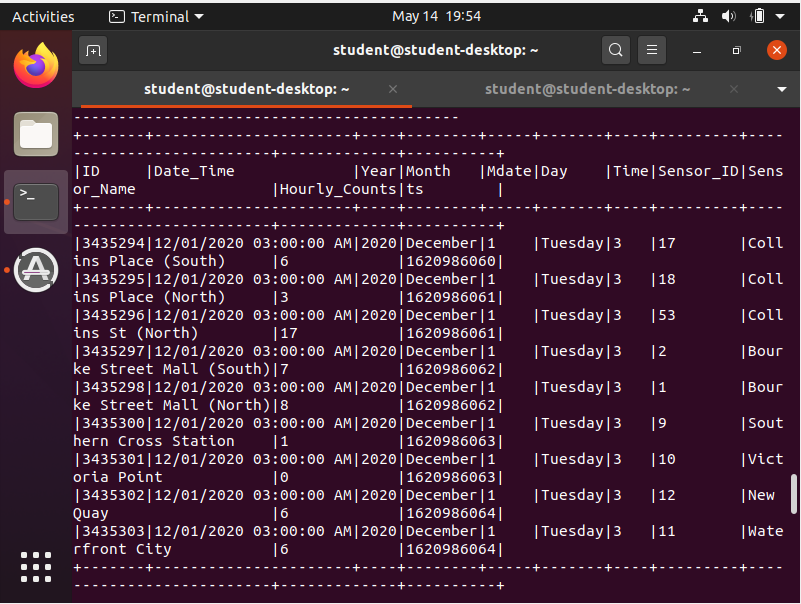

## Transform streaming data to proper formats

In [9]:
from pyspark.sql.functions import to_timestamp

raw_df = raw_df.withColumn("ID", raw_df.ID.cast(IntegerType()))
raw_df = raw_df.withColumn("Date_Time", to_timestamp(raw_df.Date_Time, 'M/d/y h:m:s a'))
raw_df = raw_df.withColumn("Year", raw_df.Year.cast(IntegerType()))
raw_df = raw_df.withColumn("Mdate", raw_df.Mdate.cast(IntegerType()))
raw_df = raw_df.withColumn("Time", raw_df.Time.cast(IntegerType()))
raw_df = raw_df.withColumn("Sensor_ID", raw_df.Sensor_ID.cast(IntegerType()))
raw_df = raw_df.withColumn("Hourly_Counts", raw_df.Hourly_Counts.cast(IntegerType()))

formatted_df = raw_df

In [10]:
formatted_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)
 |-- ts: string (nullable = true)



In [11]:
# trans_query = formatted_df.writeStream.outputMode("append").format("console").option("truncate", "false").trigger(processingTime='5 seconds').start()

In [12]:
# trans_query.stop()

## Preparing columns for model prediction

In [13]:
# Create a date format which represents the next calender date
import pyspark.sql.functions as F

formatted_df = formatted_df.withColumn("next_date", F.date_add(formatted_df['Date_Time'], 1))

In [14]:
# Create the column named “next_Mdate” based on the column “next_date” to include day of the month information
from pyspark.sql.functions import dayofmonth

formatted_df = formatted_df.withColumn("next_Mdate",dayofmonth(formatted_df["next_date"]))

In [15]:
# Create the column named “next_day_week” based on the column “next_date” to include week of the year information
from pyspark.sql.functions import weekofyear

formatted_df = formatted_df.withColumn("next_day_week", weekofyear(formatted_df["next_date"]))

In [16]:
# Create the column named “next_day_of_week” based on the column “next_date” to include day of the week information, 
# assuming Monday being the first day of week
from pyspark.sql.functions import date_format

formatted_df = formatted_df.withColumn("next_day_of_week", date_format(formatted_df["next_date"], "F"))
formatted_df = formatted_df.withColumn("next_day_of_week",formatted_df.next_day_of_week.cast(IntegerType()))

In [17]:
# Rename the column “Hourly_Count” as “prev_count”
formatted_df = formatted_df.withColumn("prev_count", formatted_df["Hourly_Counts"])

## Load the machine learning models, and use the model to predict the next day’s pedestrian count between 0am-11.59pm

In [18]:
# # unzipping the folder
# import zipfile as zf
# files = zf.ZipFile("count_estimation_pipeline_model.zip", 'r')
# files.extractall()
# files.close()

In [19]:
# Loading the saved model
from pyspark.ml import PipelineModel
pipelineModel = PipelineModel.load('count_estimation_pipeline_model')

In [20]:
formatted_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)
 |-- ts: string (nullable = true)
 |-- next_date: date (nullable = true)
 |-- next_Mdate: integer (nullable = true)
 |-- next_day_week: integer (nullable = true)
 |-- next_day_of_week: integer (nullable = true)
 |-- prev_count: integer (nullable = true)



In [21]:
# Execute prediction
prediction = pipelineModel.transform(formatted_df)

In [22]:
# Select columns of 'Sensor_ID', 'Date_Time', 'next_date' and 'prediction' as output for viewing.
res_df = prediction.select("Sensor_ID", "Date_Time", "next_date", "prediction")

pred_query = res_df.writeStream.outputMode("append").format("console").option("truncate", "false").trigger(processingTime='5 seconds').start()

In [23]:
pred_query.stop()

## Screenshot of output in console.
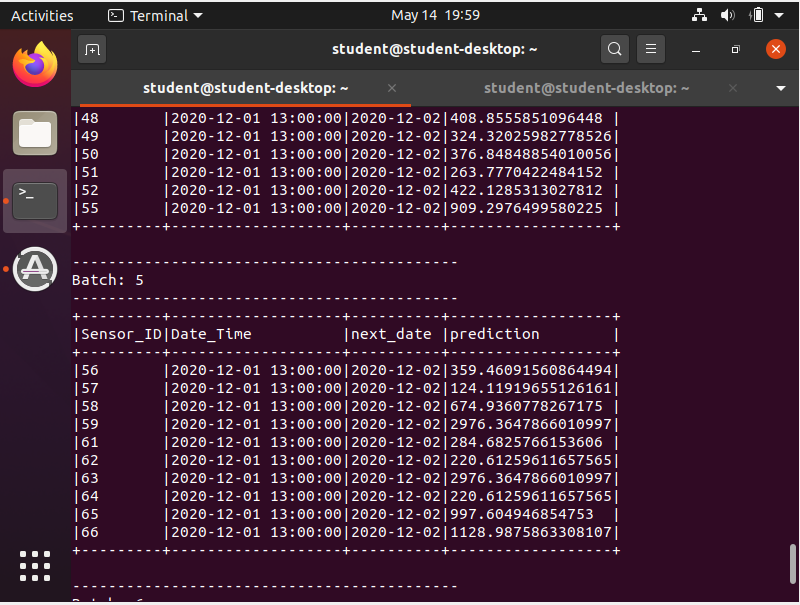

## Process the predicted data

In [24]:
from pyspark.sql.window import Window
from pyspark.sql.functions import count, col

count_df = prediction.filter(prediction.prediction > 1000)

count_df = count_df.withWatermark("Date_Time", "5 seconds")\
                    .groupBy(F.date_format(count_df.Date_Time ,"M/d/y").alias("Date"), count_df.Sensor_ID.alias("SensorID"))\
                    .count()

result_trend = count_df.join(sensor_df, sensor_df.sensor_id == count_df.SensorID,how='inner')
result_trend = result_trend.select("SensorID", "location", "Date", "count")


In [25]:
count_df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- SensorID: integer (nullable = true)
 |-- count: long (nullable = false)



In [26]:
count_query = result_trend.writeStream.outputMode("complete").format("console").option("truncate", "false").trigger(processingTime='5 seconds').start()

In [27]:
count_query.stop()

## Screenshot of output in console.
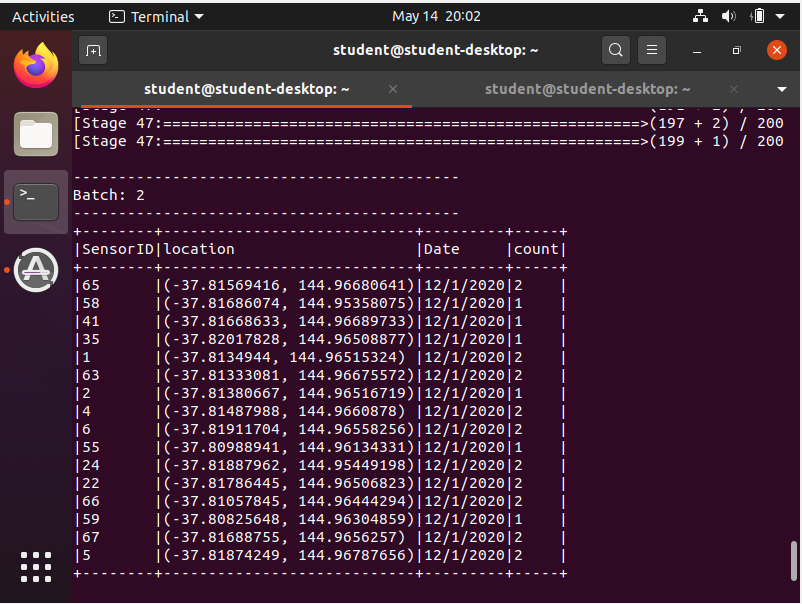